# Tranfer learning con tensor flow (Extracción de caracteristicas)

Transfer learning es la rama del aprendizaje profundo que hace uso de modelos ya construidos para aplancar la creación de nuevos modelos haciendo uso de arquitecturas y parametros ya aprendidos. Es muy util este enfoque cuando se tiene pocas muestras a la hora de entrenar el modelo.

In [ ]:
# Validar si estamos usando la GPU
!nvidia-smi # podemos ver que estamos usando una  Tesla T4 

Fri Jul  8 23:08:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Descargar y transformar los datos

In [ ]:
# Importar libreria para decomprimir ficheros
import zipfile 

# Descargar los datos
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Descomprimir los ficheros
referencia_zip = zipfile.ZipFile('10_food_classes_10_percent.zip')
referencia_zip.extractall()
referencia_zip.close()


--2022-07-09 16:14:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   211MB/s    in 0.8s    

2022-07-09 16:14:01 (211 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Cuantas imagenes hay en cada carpeta
import os

for dirpath, dirname, filenames in os.walk("10_food_classes_10_percent"):
  print(f"Hay {len(dirname)} directorios y {len(filenames)} imagenes en {dirpath}")

Hay 2 directorios y 0 imagenes en 10_food_classes_10_percent
Hay 10 directorios y 0 imagenes en 10_food_classes_10_percent/test
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/ramen
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/fried_rice
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/chicken_curry
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/chicken_wings
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/grilled_salmon
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/ice_cream
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/sushi
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/pizza
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/steak
Hay 0 directorios y 250 imagenes en 10_food_classes_10_percent/test/hamburger
Hay 10 directorios y 0 imagenes en 10_food_classes_10_percent/train
Hay 0 directorios y 75 ima

## Callback

Los callback son herramientas que agregan funcionalidades a los modelos durante el entrenamiento, evaluación o inferencia

In [ ]:
import tensorflow as tf

In [ ]:
import datetime

def create_tensorboard_callback(nombre_directorio, nombre_experimento):
  directorio_log = nombre_directorio + "/" + nombre_experimento + "/" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callbak = tf.keras.callbacks.TensorBoard(log_dir=directorio_log)
  return tensorboard_callbak

# Creando un modelo apartir de modelos en Tensor Flow hub

En este caso bamos a utilizar el Hub de tensor flow para emsanblar modelos y asi no tener la necesitas de montar nuestro modelos desde cero. Se puede acceder a estos modelo pree entrenados aqui: https://www.tensorflow.org/hub?hl=es-419

Con el proposito de encontrar el mejor modelo a usar, recurrimos a la pagina https://paperswithcode.com/ y seleccionamos el mejor model a la hora de realizar procesos de calsificación con imagenes. En este caso encontramos que el mejor rakeado es `CoCa (finetuned)`, el cual se puede encontrar en Tensor Hub como 


In [ ]:
# Definir los parametros de la entrada del modelo

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


In [ ]:
# Resnet 50 V2 
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
import tensorflow_hub as hub

# funcion para crear modelos desde el hub de Tensor flow
def crear_modelo(url_modelo:str, numero_clases=10):
  """
  Tomas la url de un un modelo almacenado en el Hub de modelos y lo crea.

  Parametros:
    url_modelo: url donde se encuentra alojado el modelo en Tensor hub
    numero_clases: Numero de neuronas en la capa de salida.

  Retorna:
    Un modelo de keras no complicado.
  """
  # Descargar el modelo pre entrenado 
  capa_extraccion_caracteristicas = hub.KerasLayer(url_modelo,
                                                   trainable=False,
                                                   name='feature_extraction_layer',
                                                   input_shape=IMAGE_SHAPE+(3,))
  modelo = tf.keras.Sequential()
  modelo.add(capa_extraccion_caracteristicas)
  modelo.add(tf.keras.layers.Dense(numero_clases, activation='softmax', name='capa_salida'))

  return modelo

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Imagenes de entrenamiento:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Imagenes de test:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Imagenes de entrenamiento:
Found 750 images belonging to 10 classes.
Imagenes de test:
Found 2500 images belonging to 10 classes.


In [ ]:
# Crear el modelo resnet ajustado a nuestro conjunto de datos
modelo_resnet = crear_modelo(resnet_url, numero_clases=train_data_10_percent.num_classes)

# compilar el modelo
modelo_resnet.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [ ]:
# Ajustamos el modelo a nuestro conjunto de datos
historia_resnet = modelo_resnet.fit(train_data_10_percent,
                                    epochs=5,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=len(test_data),
                                    # Se agrega el call back del tensor board
                                    callbacks=[create_tensorboard_callback(nombre_directorio="tensorflow_hub", # save experiment logs here
                                                                         nombre_experimento="resnet50V2")])

Epoch 1/5
24/24 [==============================] - 33s 799ms/step - loss: 2.0006 - accuracy: 0.3307 - val_loss: 1.2769 - val_accuracy: 0.5960
Epoch 2/5
24/24 [==============================] - 17s 711ms/step - loss: 0.9628 - accuracy: 0.6947 - val_loss: 0.8849 - val_accuracy: 0.7132
Epoch 3/5
24/24 [==============================] - 16s 705ms/step - loss: 0.6756 - accuracy: 0.7840 - val_loss: 0.7957 - val_accuracy: 0.7492
Epoch 4/5
24/24 [==============================] - 16s 702ms/step - loss: 0.5144 - accuracy: 0.8493 - val_loss: 0.7160 - val_accuracy: 0.7644
Epoch 5/5
24/24 [==============================] - 16s 706ms/step - loss: 0.4022 - accuracy: 0.8947 - val_loss: 0.6999 - val_accuracy: 0.7664


☝ Podemos ver que en el caso anterior auque entrenamos con el 10% de los datos de la base de datos, tuvimos valores para la exactitud de aproximadamente del 80%

In [ ]:

import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

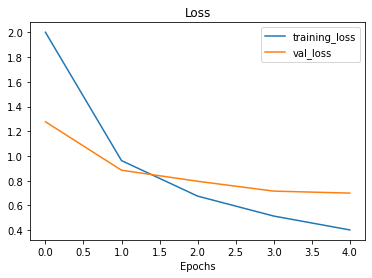

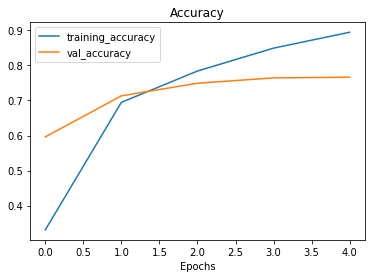

In [ ]:

plot_loss_curves(historia_resnet)

In [ ]:
# Crear el modelo resnet ajustado a nuestro conjunto de datos
modelo_efficientnet = crear_modelo(efficientnet_url, numero_clases=train_data_10_percent.num_classes)

# compilar el modelo
modelo_efficientnet.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [ ]:
# Ajustamos el modelo a nuestro conjunto de datos
historia_efficientnet = modelo_efficientnet.fit(train_data_10_percent,
                                    epochs=5,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=len(test_data),
                                    # Se agrega el call back del tensor board
                                    callbacks=[create_tensorboard_callback(nombre_directorio="tensorflow_hub", # save experiment logs here
                                                                         nombre_experimento="efficientnet")])

Epoch 1/5
24/24 [==============================] - 25s 713ms/step - loss: 1.9369 - accuracy: 0.3827 - val_loss: 1.3640 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 15s 648ms/step - loss: 1.1009 - accuracy: 0.7787 - val_loss: 0.8884 - val_accuracy: 0.8232
Epoch 3/5
24/24 [==============================] - 16s 701ms/step - loss: 0.7697 - accuracy: 0.8387 - val_loss: 0.6995 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 15s 648ms/step - loss: 0.6132 - accuracy: 0.8773 - val_loss: 0.6112 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 16s 673ms/step - loss: 0.5189 - accuracy: 0.8973 - val_loss: 0.5593 - val_accuracy: 0.8696
